# Introduction

# Data cleaning and pre processing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
data = pd.read_csv('data/diabetic_data.csv')

In [5]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

In [6]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Counting missing values for each feature

### Nan Values

In [7]:
data.shape

(101766, 50)

In [8]:
na_values = data.isna().sum(axis=0)

print(na_values[na_values > 0]/len(data) * 100)

max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


Apparently, max_glu_serum and A1Cresults are the only features with 'Nan' values. We can easily drop these columns, as these features are categorical so they cannot be inferred in any way. 


In [9]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [10]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [11]:
data = data.drop(columns=['max_glu_serum', 'A1Cresult'])

### Other missing values

Taking a look at the datasaet, it is clear that for some features missing values are indicated by a question mark rathen than being nan values. Let's count missing values for each column

In [12]:
for col in data.columns:
    missing_values = data.loc[data[col] == '?', col].value_counts()
    if len(missing_values.values > 0):
        print(col, missing_values.values/len(data) * 100)

race [2.23355541]
weight [96.85847926]
payer_code [39.55741603]
medical_specialty [49.0822082]
diag_1 [0.02063558]
diag_2 [0.35178743]
diag_3 [1.39830592]


From the results above, we find that the feature 'weight' is available only for 3% of the observations! This column can be dropped. We also find that 49% of observations do not have values for medical_speciality and 39% do not have values for payer_code. These two are both categorical variables, so we cannot use the mean or other statistics to replace missing values. So, they can easily be dropped
diag_1, diag_2 and diag_3 are diagnosis so they cannot be inferred. In a classification setting these features can cleary be useful. Suppose the primary diagnosis is correct: intuitevely, a patient with a correct diagnosis has a less probability of returning to the hospital rather than a patient with n incorrect diaagnosis. Rather than drop the columns it is wiser to drop the observations with missing diagnosis.

In [13]:
data = data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [14]:
data.shape

(101766, 45)

In [15]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data is now ready for the analysis pipeline!

## Renaiming some columns

To avoid potential failure when using statsmodel, we rename the columns that contains a '-' in their name.

In [16]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

## Removing outliers

In [17]:
data[data['gender'] == 'Unknown/Invalid']
data = data.drop(index=[30506, 75551, 82573])

# Exploratory data analysis

## What is the most frequent readmission type?

In [18]:
freqs = data['readmitted'].value_counts(normalize=True).sort_index()
print(freqs)

readmitted
<30    0.111602
>30    0.349292
NO     0.539106
Name: proportion, dtype: float64


<Axes: xlabel='readmitted'>

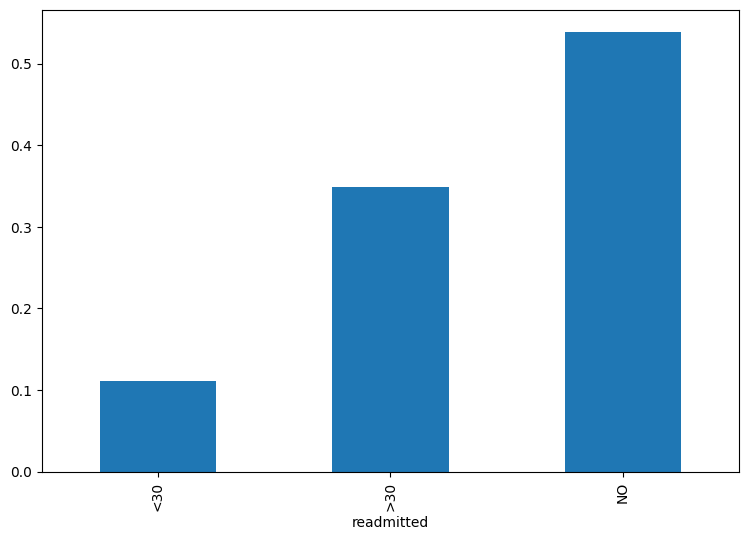

In [19]:
freqs.plot.bar(figsize=(9, 6))

The dataset is very imbalanced. Only 10% of observations represents class "readmitted within 30 days". 

## What is the distribution of gender between readmissions?

## Distribution of gender

In [20]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [21]:
freqs = data['gender'].value_counts(normalize=True)
print(freqs)

gender
Female    0.537602
Male      0.462398
Name: proportion, dtype: float64


<Axes: xlabel='gender'>

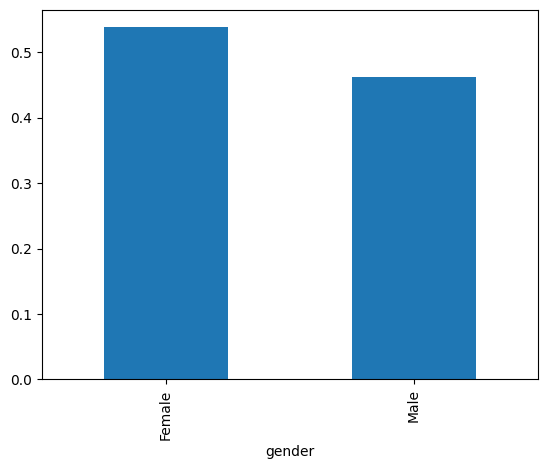

In [22]:
freqs.plot.bar()

Let's count how many patients with 'unknown/invalid' gender are there in the dataset

In [23]:
data['gender'].value_counts().sort_index()

gender
Female    54708
Male      47055
Name: count, dtype: int64

## Distribution of gender between readmissions

<Axes: xlabel='gender'>

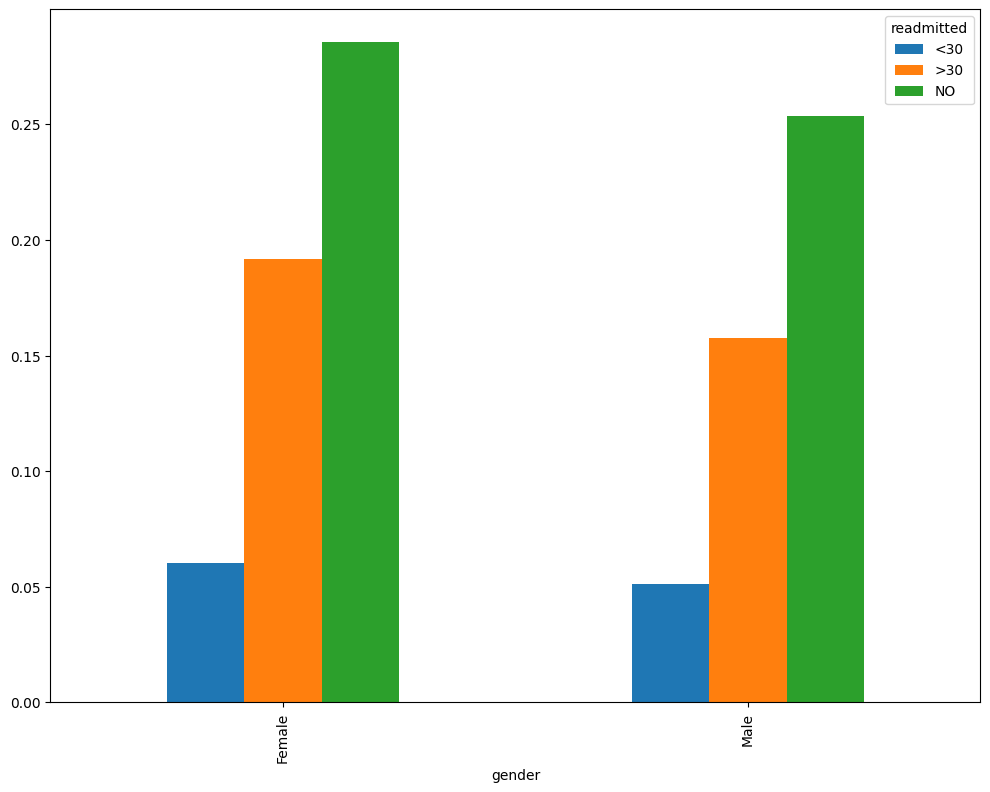

In [24]:
d = data[['gender', 'readmitted']]

cont_table = pd.crosstab(index=d['gender'], columns=data['readmitted'], normalize=True)

cont_table.plot.bar(figsize=(12, 9))

<Axes: xlabel='gender'>

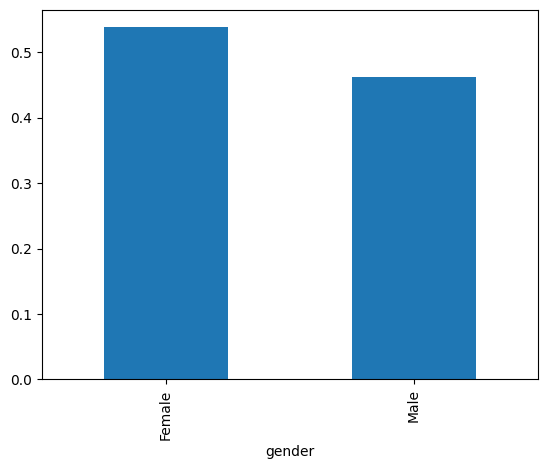

In [25]:
freqs.plot.bar()

## Distribution of age

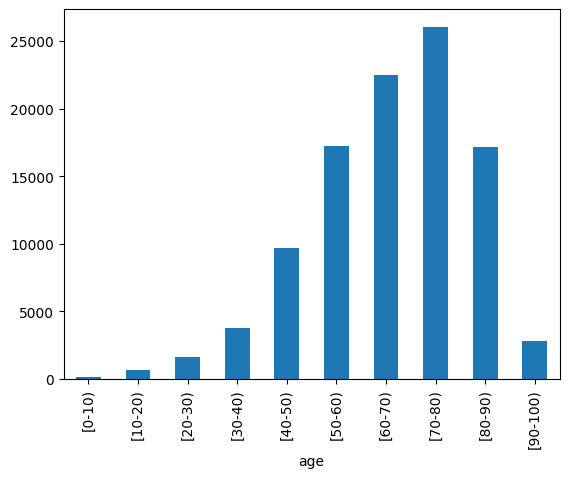

In [26]:
freqs = data['age'].value_counts().sort_index().plot.bar()

In [27]:
cont_table = pd.crosstab(index=data['age'], columns=data['readmitted'], normalize=True)
cont_table

readmitted,<30,>30,NO
age,,,
[0-10),0.000029,0.000255,0.001297
[10-20),0.000393,0.002201,0.004196
[20-30),0.002319,0.005012,0.008952
[30-40),0.004167,0.011664,0.021265
[40-50),0.010092,0.032212,0.052868
[50-60),0.016391,0.058145,0.095035
[60-70),0.024587,0.077602,0.118737
[70-80),0.030158,0.093108,0.132877
[80-90),0.020420,0.061152,0.087419


<Axes: xlabel='age'>

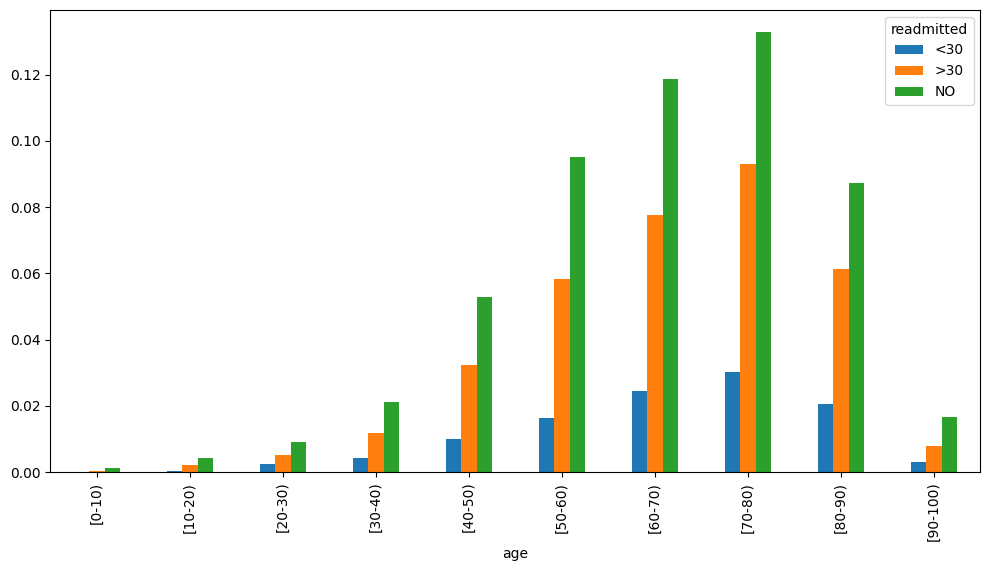

In [28]:
cont_table.plot.bar(figsize=(12, 6))

From the plot above, we can say that the distribution of age is similar between readmisssions types.

# Preparing data for further analysis

In [29]:
data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_17972\3738235945.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)


Let's drop some variables about administrative data

In [30]:
data.drop(columns=['encounter_id', 'patient_nbr', 'race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'examide', 'citoglipton',
                          'diag_1', 'diag_2', 'diag_3'], inplace=True)

Variables "citoglipton" and "examide" have identical values for each observations. so we need to remove them in order to build models for inferential or predictive analysis

# Inferential Analysis

## What is the average time in hospital?

In [31]:
mean = data['time_in_hospital'].mean()
print(mean)

4.396018199149003


From the results above, we find that the average time in hospital is 4 days.

<Axes: >

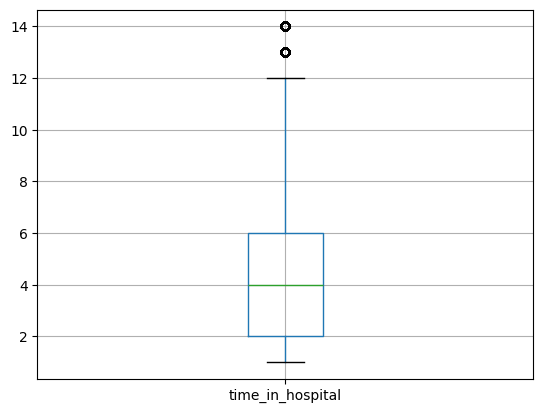

In [32]:
data.boxplot(column=['time_in_hospital'])

From the box plot above, we notice that values 13 and 14 are outliers. The median value is 4 and the third quantile is 6. 

## What is the average time in hospital between readmission classes?

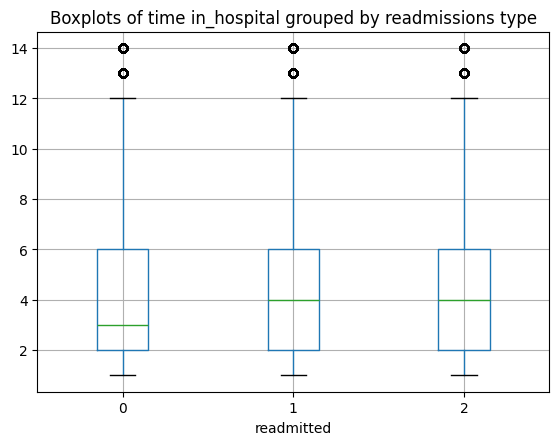

In [33]:
ax = data.boxplot(by='readmitted', column='time_in_hospital')

ax.set_title("Boxplots of time in_hospital grouped by readmissions type")
plt.suptitle("")
plt.show()

In [34]:
import seaborn as sns

<Axes: xlabel='readmitted', ylabel='time_in_hospital'>

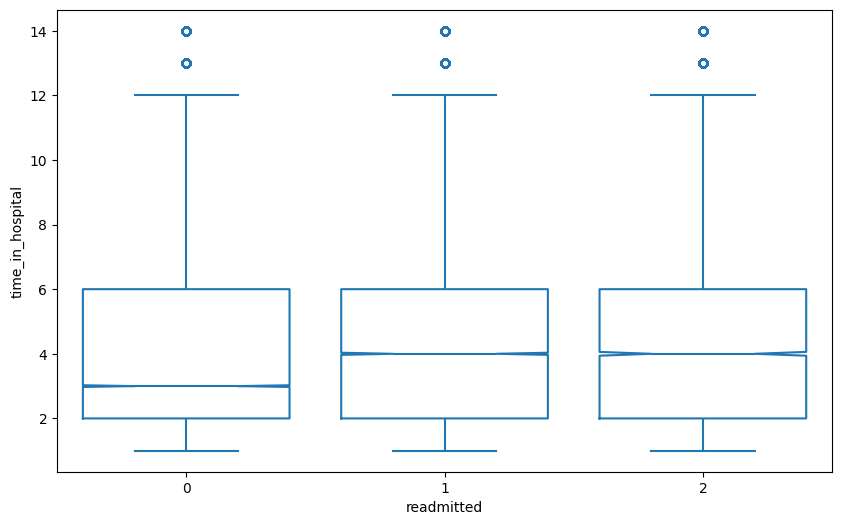

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data, x='readmitted', y='time_in_hospital', notch=True, fill=False)

### Average time in hospital for not-readmitted patients

In [36]:
not_readmitted = data.loc[data['readmitted'] == 0, 'time_in_hospital']
mean_not_readmitted = not_readmitted.mean()
print(mean_not_readmitted)

4.254479502743297


### Average time in hospital for readmitted patients

In [37]:
readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital']
mean_readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital'].mean()
print(mean_readmitted)

4.56157519935184


Is this due to chance or is it statistically significant? Let's run a statistical test to see if we can reject the hypothesis that the two means are equal. 

In [38]:
t, p = stats.ttest_ind(readmitted, not_readmitted)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  3.1662864432201493e-60 
Alpha:  0.05


We can reject the null hyphothesis. It is safe to say that the two populations mean are different. 

### What about the medians?

For class 0, the median is lower than the other two. This means that the distribution of time_in_hospital for patients of class 0 is not symmetrical. <br> <br> Moreover, the median for classes 1 and 2 is equal. Is this due to chance or it is statistically significant? Let's run a test to find out.

In [39]:
readmitted_within = data.loc[data['readmitted'] == 1, 'time_in_hospital']

In [40]:
readmitted_after = data.loc[data['readmitted'] == 2, 'time_in_hospital']


In [41]:
_, p = stats.kruskal(readmitted_within, readmitted_after)

print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.1633727428594765e-21 
Alpha:  0.05


We can reject the null hypothesis that the two medians are equals. We can say that the two meadians actually differs.

What about the other group?

In [42]:
_, p = stats.kruskal(not_readmitted, readmitted_within)

print("P value: ", p, "\nAlpha: ", alpha)

P value:  9.590703963727032e-47 
Alpha:  0.05


In [43]:
_, p = stats.kruskal(not_readmitted, readmitted_after)

print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.594974370157433e-83 
Alpha:  0.05


The three groups actually differ from each other.

## Simple logit regression

Let's fit a logistic regressor to study the relationship between time_in_hospital and readmitted. Let's see if an increase of the variable "time_in_hospital" leads to an increase in the probability that a patient will be readmitted or not. 

In [44]:
from statsmodels.formula.api import logit, mnlogit

### Preparing the data

To do this, it is not necessary to use three class of readmissions, instead it sufficient to know if a patient has been readmitted or not.

In [45]:
data['readmitted'].unique()

array([0, 1, 2])

In [46]:
data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
                             '[30-40)': 35, '[40-50)': 45, '[50-60)': 55,
                             '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95,
                            }, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_17972\2554642332.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_17972\2554642332.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data

In [47]:
view = data.replace({'readmitted': {2: 1}})

In [48]:
view['readmitted'].unique()

array([0, 1])

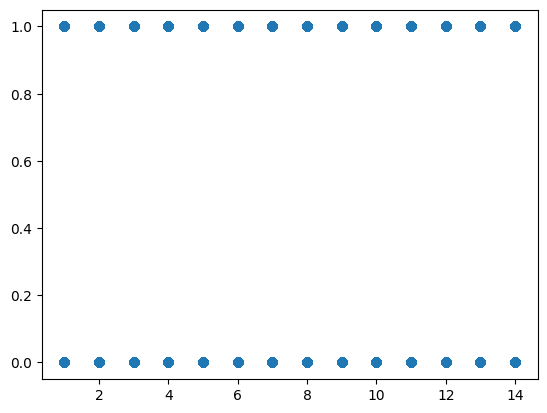

In [49]:
plt.scatter(x=view['time_in_hospital'], y=view['readmitted'])

### Simple logit regression

We can now fit a simple logit regressor

In [50]:
model = logit('readmitted ~ time_in_hospital', view).fit()

Optimization terminated successfully.
         Current function value: 0.688772
         Iterations 4


In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101761
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                0.001903
Time:                        18:35:52   Log-Likelihood:                -70092.
converged:                       True   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                 4.513e-60
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3084      0.011    -27.461      0.000      -0.330      -0.286
time_in_hospital     0.0344      0.002     16.331      0.000       0.030       0.039
====================================================================================
"""

The pseudo-R^2 is very small: the model do not explain well the data.

In [52]:
np.exp(-0.3085)

np.float64(0.7345479521991701)

when time_in_hospital is set to 0, unrealistically, the odds of a patient being readmitted rather than not is 0.73. 

In [53]:
np.exp(0.0344)

np.float64(1.0349985233486143)

Without considering other variables, an extra day in hospital corresponds to a multiplicative increase in the odds of a patient being readmitted rather than not of 1.034. That is, if a patient spend an extra day in the hospital, the odds of being readmitted increases by a (1-1.034)*100 = 3.4%

## Simple multivariate logit regressor

In [54]:
model = mnlogit('readmitted ~ time_in_hospital', data).fit()

Optimization terminated successfully.
         Current function value: 0.943567
         Iterations 6


In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                        MNLogit   Df Residuals:                   101759
Method:                           MLE   Df Model:                            2
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                0.001736
Time:                        18:35:55   Log-Likelihood:                -96020.
converged:                       True   LL-Null:                       -96187.
Covariance Type:            nonrobust   LLR p-value:                 3.001e-73
====================================================================================
    readmitted=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5537      0.012    -45.590      0.000      -0.577      -0.530
time_in_hospital     0.0274      0.002     11.964      0.000       0.023       0.032
------------------------------------------------------------------------------------
    readmitted=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.8253      0.019    -98.340      0.000      -1.862      -1.789
time_in_hospital     0.0556      0.003     16.817      0.000       0.049       0.062
====================================================================================
"""

In [56]:
np.exp(0.0556)

np.float64(1.0571747292596514)

This model only explains 0.0017% of variability in the data! Let's build a more complex models involving the other variables.

## Multiple logistic regression

In [57]:
view = data.replace({'readmitted': 2}, 1)

We need to introduce dummy variables for each categorical variable in order to build a logit regressor

In [58]:
cols = np.concatenate([[view.columns[0]], view.columns[10:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

In [59]:
cols

array(['gender', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed'], dtype=object)

## Removing correlated categorical variables using Cramer's V statistic

There are variables correleated with each other. To remove them, let's compute V-Cramer statistic to find these variables and remove them from the model

In [60]:
from scipy.stats.contingency import association

In [61]:
def buildVMatrix(df):
    l = []
    cat_vars = df.select_dtypes(include=['uint8']).columns
    v_mat = pd.DataFrame(index = cat_vars, columns= cat_vars)

    for var_one in cat_vars:
        for var_two in cat_vars:
            v = association(pd.crosstab(view[var_one], view[var_two]))
            v_mat.loc[var_one, var_two] = v
            
            if var_one != var_two and v >= 0.9:
                el = [var_one, var_two]
                el.sort()
                
                #usare un set
                if el[1] not in l:
                    l.append(el[1])
    return l
            

lasso + togliere variabili

In [62]:
vars_to_drop = buildVMatrix(view)
view = view.drop(columns=vars_to_drop)

## Building the model

In [63]:
import statsmodels.api as sm

exog = view.drop(columns='readmitted')
exog = sm.add_constant(exog)
endog = view['readmitted']

In [64]:
model = sm.Logit(endog, exog).fit()

         Current function value: 0.652383
         Iterations: 35


c:\Users\Raffaele\miniconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101714
Method:                           MLE   Df Model:                           48
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.05463
Time:                        18:36:52   Log-Likelihood:                -66388.
converged:                      False   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.1595      0.481      0.332      0.740      -0.782       1.101
age                                 0.0023      0.000      5.201      0.000       0.001       0.003
time_in_hospital                    0.0113      0.003      4.399      0.000       0.006       0.016
num_lab_procedures                  0.0015      0.000      4.136      0.000       0.001       0.002
num_procedures                     -0.0455      0.004    -10.693      0.000      -0.054      -0.037
num_medications                     0.0005      0.001      0.495      0.621      -0.002       0.003
number_outpatient                   0.0824      0.006     13.713      0.000       0.071       0.094
number_emergency                    0.2172      0.012     17.667      0.000       0.193       0.241
number_inpatient                    0.3694      0.007     53.247      0.000       0.356       0.383
number_diagnoses                    0.0782      0.004     21.045      0.000       0.071       0.086
gender_Male                        -0.0487      0.013     -3.694      0.000      -0.075      -0.023
metformin_No                        0.1267      0.020      6.199      0.000       0.087       0.167
metformin_Up                       -0.0648      0.066     -0.985      0.325      -0.194       0.064
repaglinide_No                     -0.1774      0.056     -3.140      0.002      -0.288      -0.067
repaglinide_Up                     -0.2996      0.204     -1.467      0.142      -0.700       0.101
nateglinide_No                     -0.0429      0.080     -0.537      0.592      -0.200       0.114
nateglinide_Up                     -0.2787      0.441     -0.632      0.528      -1.143       0.586
chlorpropamide_No                  -0.0247      0.230     -0.107      0.915      -0.476       0.427
chlorpropamide_Up                   1.6831      1.126      1.495      0.135      -0.524       3.890
glimepiride_No                     -0.0155      0.033     -0.473      0.636      -0.080       0.049
glimepiride_Up                     -0.1806      0.119     -1.519      0.129      -0.413       0.052
acetohexamide_Steady               19.6285   1.58e+04      0.001      0.999    -3.1e+04    3.11e+04
glipizide_No                       -0.0889      0.024     -3.691      0.000      -0.136      -0.042
glipizide_Up                        0.0630      0.077      0.822      0.411      -0.087       0.213
glyburide_No                       -0.0142      0.026     -0.544      0.586      -0.065       0.037
glyburide_Up                       -0.0535      0.076     -0.706      0.480      -0.202       0.095
tolbutamide_Steady                 -0.4454      0.444     -1.004      0.315      -1.315       0.424
pioglitazone_No                    -0.0666      0.028     -2.422      0.015      -0.121      -0.013
pioglitazone_Up                     0.1439      0.137      1.052      0.293      -0.124       0.412
rosiglitazone_No                   -0.121

We have many variables with a high p-value. Let's build a better model with backwward selection

## Backward selection

In [66]:
import warnings
warnings.simplefilter('ignore')

In [67]:
model.pvalues

const                              7.399921e-01
age                                1.977037e-07
time_in_hospital                   1.089880e-05
num_lab_procedures                 3.531504e-05
num_procedures                     1.094315e-26
num_medications                    6.209227e-01
number_outpatient                  8.433009e-43
number_emergency                   7.524656e-70
number_inpatient                   0.000000e+00
number_diagnoses                   2.541710e-98
gender_Male                        2.211046e-04
metformin_No                       5.692348e-10
metformin_Up                       3.245874e-01
repaglinide_No                     1.690782e-03
repaglinide_Up                     1.423404e-01
nateglinide_No                     5.916046e-01
nateglinide_Up                     5.276217e-01
chlorpropamide_No                  9.145028e-01
chlorpropamide_Up                  1.350438e-01
glimepiride_No                     6.360398e-01
glimepiride_Up                     1.286

In [68]:
view_bs = view
model_og = model

ll_values = [model_og.llf]
rsqr_values = [model_og.prsquared]

a = 0.05 #significance level
count = 1

while True:
    p_values = model.pvalues.drop("const")

    p = np.max(p_values)
    i = np.argmax(p_values)

    if p > a:
        count = count + 1
        exog = exog.drop(columns=p_values.index[i])
        model = sm.Logit(endog, exog).fit(disp=False)
        
        ll_values.append(model.llf)
        rsqr_values.append(model.prsquared)
        
    else:
        break
    
print(count, "variables removed")

29 variables removed


In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101742
Method:                           MLE   Df Model:                           20
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.05441
Time:                        18:37:24   Log-Likelihood:                -66405.
converged:                       True   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.6600      0.150     -4.397      0.000      -0.954      -0.366
age                    0.0023      0.000      5.246      0.000       0.001       0.003
time_in_hospital       0.0117      0.002      4.868      0.000       0.007       0.016
num_lab_procedures     0.0015      0.000      4.185      0.000       0.001       0.002
num_procedures        -0.0447      0.004    -11.305      0.000      -0.052      -0.037
number_outpatient      0.0824      0.006     13.735      0.000       0.071       0.094
number_emergency       0.2170      0.012     17.658      0.000       0.193       0.241
number_inpatient       0.3696      0.007     53.347      0.000       0.356       0.383
number_diagnoses       0.0786      0.004     21.424      0.000       0.071       0.086
gender_Male           -0.0486      0.013     -3.692      0.000      -0.074      -0.023
metformin_No           0.1365      0.018      7.723      0.000       0.102       0.171
repaglinide_No        -0.1495      0.054     -2.782      0.005      -0.255      -0.044
glipizide_No          -0.0848      0.020     -4.140      0.000      -0.125      -0.045
pioglitazone_No       -0.0663      0.026     -2.588      0.010      -0.116      -0.016
rosiglitazone_No      -0.1161      0.028     -4.204      0.000      -0.170      -0.062
rosiglitazone_Up      -0.4158      0.160     -2.593      0.010      -0.730      -0.102
acarbose_No           -0.4045      0.120     -3.364      0.001      -0.640      -0.169
insulin_No            -0.0699      0.024     -2.878      0.004      -0.117      -0.022
insulin_Steady        -0.1984      0.022     -8.866      0.000      -0.242      -0.155
insulin_Up            -0.0686      0.027     -2.521      0.012      -0.122      -0.015
diabetesMed_Yes        0.3022      0.022     13.737      0.000       0.259       0.345
======================================================================================
"""

Number_inpatient is the variable with the highest coefficient. When all the other variables are held constant, an increase of one unit in number_inpatient corresponds to a multiplicative increase in the odds of a patient being readmitted rather than not of:


In [70]:
np.exp(0.3696)

np.float64(1.4471556366207874)

That is, the odds increase by a $+4,5 \% $. However, the pseudo r-squared is still very low. Let's plot the variation in this statistic as a function of the number of variables removed during backward selection:

Text(0.5, 1.0, 'Variation in pseudo r-squared as a function of the number of variables removed')

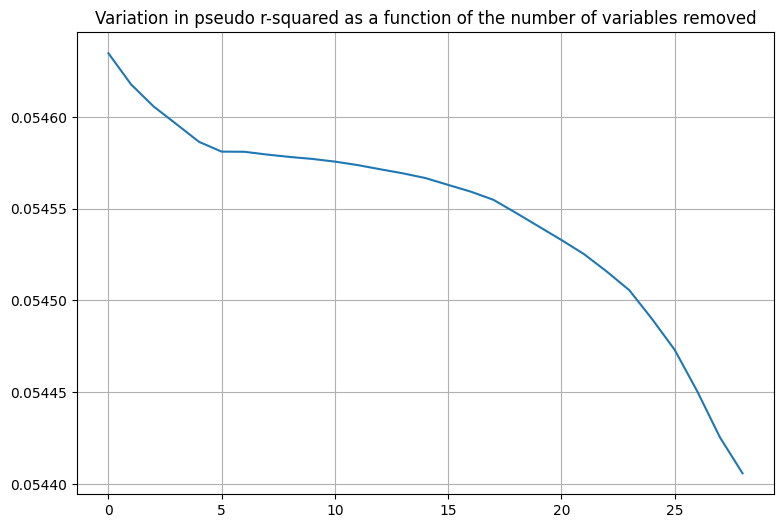

In [71]:
plt.figure(figsize=(9, 6))
plt.plot(range(0, count), rsqr_values)
plt.grid()
plt.title("Variation in pseudo r-squared as a function of the number of variables removed")

The pseudo r-squared has slightly decreased: from $0.5463$ to $0.05441$ << 1. <br>

## Using Lasso regression to perform variable selection

Despite lasso regression being not interpretable, we can use it to perform variable selection and then build a logit regressor. Let's see if we can obtain a bigger pseudo r-squared with this method.

In [72]:
view = data.replace({'readmitted': 2}, 1)
cols = np.concatenate([[view.columns[0]], view.columns[10:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

In [73]:
from scipy.stats import zscore

In [74]:
exog = zscore(view.drop(columns='readmitted'), axis=1)

In [75]:
exog = sm.add_constant(exog)
model_lasso = sm.Logit(exog=exog, endog=view['readmitted']).fit_regularized(L1_wt=1, alpha=36, maxiter=10000)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6590767289933417
            Iterations: 260
            Function evaluations: 261
            Gradient evaluations: 260


Our lasso regressor has set to zero some coefficients:

In [76]:
zero_coeff = model_lasso.params[model_lasso.params == 0]

print(zero_coeff.sort_index())

acarbose_Steady                    0.0
acarbose_Up                        0.0
acetohexamide_Steady               0.0
chlorpropamide_No                  0.0
chlorpropamide_Steady              0.0
chlorpropamide_Up                  0.0
glimepiride_Steady                 0.0
glimepiride_Up                     0.0
glimepiride_pioglitazone_Steady    0.0
glipizide_Steady                   0.0
glipizide_Up                       0.0
glipizide_metformin_Steady         0.0
glyburide_Steady                   0.0
glyburide_Up                       0.0
glyburide_metformin_No             0.0
glyburide_metformin_Steady         0.0
glyburide_metformin_Up             0.0
insulin_Up                         0.0
metformin_No                       0.0
metformin_Up                       0.0
metformin_pioglitazone_Steady      0.0
metformin_rosiglitazone_Steady     0.0
miglitol_No                        0.0
miglitol_Steady                    0.0
miglitol_Up                        0.0
nateglinide_No           

In [77]:
zero_coeff.index.values

array(['metformin_No', 'metformin_Up', 'repaglinide_Steady',
       'repaglinide_Up', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up', 'chlorpropamide_No', 'chlorpropamide_Steady',
       'chlorpropamide_Up', 'glimepiride_Steady', 'glimepiride_Up',
       'acetohexamide_Steady', 'glipizide_Steady', 'glipizide_Up',
       'glyburide_Steady', 'glyburide_Up', 'tolbutamide_Steady',
       'pioglitazone_Steady', 'pioglitazone_Up', 'rosiglitazone_Steady',
       'rosiglitazone_Up', 'acarbose_Steady', 'acarbose_Up',
       'miglitol_No', 'miglitol_Steady', 'miglitol_Up',
       'troglitazone_Steady', 'tolazamide_Steady', 'tolazamide_Up',
       'insulin_Up', 'glyburide_metformin_No',
       'glyburide_metformin_Steady', 'glyburide_metformin_Up',
       'glipizide_metformin_Steady', 'glimepiride_pioglitazone_Steady',
       'metformin_rosiglitazone_Steady', 'metformin_pioglitazone_Steady'],
      dtype=object)

Let's drop these variables:

In [78]:
exog = exog.drop(columns=zero_coeff.index.values)

In [79]:
len(exog.columns)

23

Now we only have 23 variables. Let's fit a new intepretable logit regressor on these variables:

In [80]:
model_final = sm.Logit(exog=exog, endog=view['readmitted']).fit(disp=False)

In [81]:
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101740
Method:                           MLE   Df Model:                           22
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.05534
Time:                        18:37:32   Log-Likelihood:                -66339.
converged:                       True   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3934      0.157     -2.501      0.012      -0.702      -0.085
age                   -0.1054      0.023     -4.612      0.000      -0.150      -0.061
time_in_hospital       0.0254      0.030      0.834      0.404      -0.034       0.085
num_lab_procedures    -0.1164      0.018     -6.367      0.000      -0.152      -0.081
num_procedures        -0.6479      0.045    -14.372      0.000      -0.736      -0.560
num_medications       -0.1340      0.018     -7.587      0.000      -0.169      -0.099
number_outpatient      0.6678      0.063     10.605      0.000       0.544       0.791
number_emergency       1.7765      0.119     14.950      0.000       1.544       2.009
number_inpatient       3.5581      0.073     48.991      0.000       3.416       3.700
number_diagnoses       0.5412      0.034     16.112      0.000       0.475       0.607
gender_Male           -0.6117      0.132     -4.627      0.000      -0.871      -0.353
metformin_Steady      -1.3079      0.194     -6.745      0.000      -1.688      -0.928
repaglinide_No        -2.5406      0.535     -4.747      0.000      -3.590      -1.492
glimepiride_No        -0.3325      0.307     -1.083      0.279      -0.934       0.269
glipizide_No          -1.1029      0.223     -4.946      0.000      -1.540      -0.666
glyburide_No          -0.2093      0.242     -0.866      0.387      -0.683       0.265
pioglitazone_No       -0.7819      0.260     -3.004      0.003      -1.292      -0.272
rosiglitazone_No      -1.1659      0.274     -4.256      0.000      -1.703      -0.629
acarbose_No           -5.7341      0.853     -6.721      0.000      -7.406      -4.062
insulin_No            -1.1626      0.288     -4.030      0.000      -1.728      -0.597
insulin_Steady        -2.0129      0.226     -8.904      0.000      -2.456      -1.570
change_No              0.4011      0.223      1.799      0.072      -0.036       0.838
diabetesMed_Yes        2.4437      0.223     10.961      0.000       2.007       2.881
======================================================================================
"""

We have slightly increased the pseudo r-squared: $0.05452$, however it is still very low: our model can explains only 0.05% of the variability in the data. We can say the logistic regression is not a good model to explain the data

# Predictive Analysis

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In this section we will create some classifiers to make predictions about data. We have a target, readmitted, with 3 classes: 
* not readmitted (0)
* readmitted within 30 days (1)
* readmitted after 30 days (2)

However, class 2 is only represented by 10% of the observations. The data has clearly an inbalance problem. At first, before being more specific, we can classify a patient in two classes: either, a patient will be readmitted (sooner or later) or not.
 

In [83]:
view = data.replace({"readmitted": {2: 1}})

<Axes: xlabel='readmitted'>

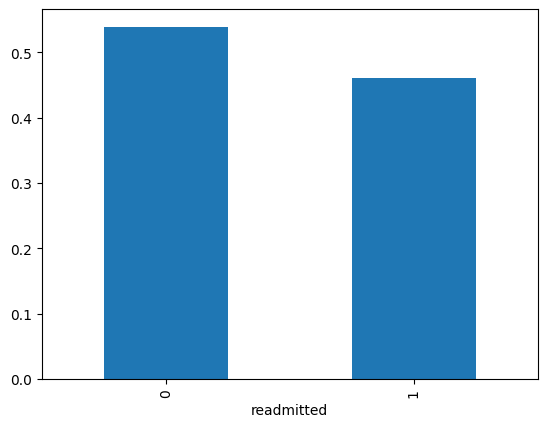

In [84]:
view['readmitted'].value_counts(normalize=True).sort_index().plot.bar()

Classes now look more balanced.

In [85]:
cols = np.concatenate([[view.columns[0]], view.columns[9:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

## Which metric is more important?

In [86]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, fbeta_score

In this context, false negatives are more important than false positives. In fact, if we say that a patient will be readmitted sooner or later even if he or she is wrong, a later test in the hospital will correct our prediction. If, on the other hand, we say that a patient will not be readmitted even if he or she is wrong, we may risk the patient's life. We can say that **in this context recall is more important than precision**. Because of this, we will use the fbeta_score with $\beta= 2$ as follows:
$$F_{2} = \frac{5*TP}{5*TP + FP + 4FN}  $$
We setted $\beta = 2$ to make recall twice as important as precision.
For more details, see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html.

We will compare multiple classifiers. For each, we will evaluate the scores above. Let's create a dataframe that will help us choose the best classifier.

In [87]:
scores_df = pd.DataFrame(index=['recall_score', 'precision_score', 'accuracy', 'f1_score', 'fbeta_score'])

In [88]:
scores_df

""
recall_score
precision_score
accuracy
f1_score
fbeta_score


## Train and test set split

In [89]:
train_set, test_set, y_train, y_test = train_test_split(view.drop(columns='readmitted'), view['readmitted'], test_size=0.25)
print(len(train_set), len(test_set))

76322 25441


## Logistic Regression for predictive analysis

Let's build a logit regressor to perform prediction on unseen data. We'll user our train set to train the model.

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

log_regr = LogisticRegression(penalty=None).fit(train_set, y_train)

In [91]:
y_pred = log_regr.predict(test_set) #treshold of 0.5

In [92]:
y_pred

array([1, 0, 1, ..., 0, 0, 1])

In [93]:
scores_df['LR'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [94]:
scores_df

,LR
recall_score,0.403588
precision_score,0.650958
accuracy,0.626037
f1_score,0.498260
fbeta_score,0.436785


In [95]:
log_regr.predict_proba(test_set)[:, 0]

array([0.38252271, 0.72020745, 0.44731121, ..., 0.6188408 , 0.54431961,
       0.48137581])

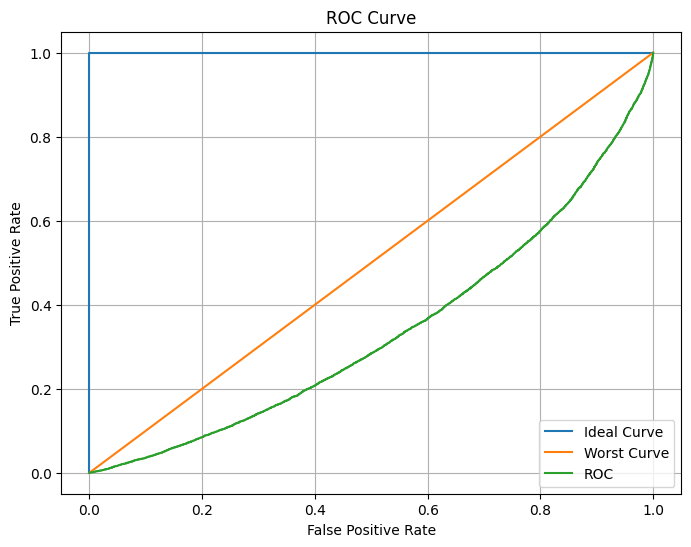

In [96]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=log_regr.predict_proba(test_set)[:, 0])
worst_curve = np.linspace(0,1,100)
ideal_curve = np.ones(100)

plt.figure(figsize = (8, 6))
plt.plot([0]+list(worst_curve),[0]+list(ideal_curve))
plt.plot(worst_curve, worst_curve)
plt.plot(fpr,tpr)

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(['Ideal Curve','Worst Curve', 'ROC'])

plt.show()

The ROC curve for our logit regressor is under the worst curve (a random predictor). Our model performs poorly. Can we do better using polynomial features?

### Polynomial Expansion

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

We'll use a Pipeline object to perform in succession polynomial expansion and logistic regression. 
To choose the best degree, we perform grid search and cross validation.

In [104]:
pol_regr = Pipeline([
    ('polynomial_expansion', PolynomialFeatures()),
    ('logit_regressor', LogisticRegression(penalty=None))
])

# Imposta il grado dell'espansione polinomiale

In [125]:
pol_regr = Pipeline([
    ('polynomial_expansion', PolynomialFeatures()),
    ('logit_regressor', LogisticRegression(penalty=None))
])


gs = GridSearchCV(pol_regr, param_grid={'polynomial_expansion__degree':range(1, 10)},
                  scoring=make_scorer(fbeta_score, beta=2))

gs.fit(train_set, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polynomial_expansion',
                                        PolynomialFeatures()),
                                       ('logit_regressor',
                                        LogisticRegression(penalty=None))]),
             param_grid={'polynomial_expansion__degree': range(1, 10)},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [111]:
gs = gs.fit(train_set, y_train)

In [126]:
gs.best_params_

{'polynomial_expansion__degree': 1}

The expansion leading to the best $F_2$ score has degree 1, which means that we can't do better than our linear model!
Let's see if we can do better using Ridge and Lasso (logit) regression, other than polynomial expansion. 

### Ridge Regression

In [181]:
pol_regr = Pipeline([
    ('polynomial_expansion', PolynomialFeatures()),
    ('logit_regressor', LogisticRegression(penalty='l2'))
])

In [ ]:


gs = GridSearchCV(pol_regr, param_grid={'polynomial_expansion__degree': range(1, 5),
                                        'logit_regressor__C': np.arange(1.0, 0, -0.1)},
                  scoring=make_scorer(fbeta_score, beta=2))

gs.fit(train_set, y_train)

In [182]:
gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Again, a degree greather than 1 leads to no increase in the F_2 score. However, we find out that the best regularization term is 0.8. Let's fit a ridge regressor:

In [183]:
pol_regr.set_params(polynomial_expansion__degree=1, logit_regressor__C = 0.8)

Pipeline(steps=[('polynomial_expansion', PolynomialFeatures(degree=1)),
                ('logit_regressor', LogisticRegression(C=0.8))])

In [184]:
pol_regr = pol_regr.fit(train_set, y_train)

In [188]:
y_pred = pol_regr.predict(test_set)
scores_df['LR_Ridge'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [189]:
scores_df

,LR,LR_Lasso,LR_Lasso2,LR_Ridge
recall_score,0.403588,0.400000,0.402050,0.403161
precision_score,0.650958,0.650278,0.650449,0.651436
accuracy,0.626037,0.624975,0.625486,0.626155
f1_score,0.498260,0.495319,0.496938,0.498074
fbeta_score,0.436785,0.433358,0.435297,0.436427


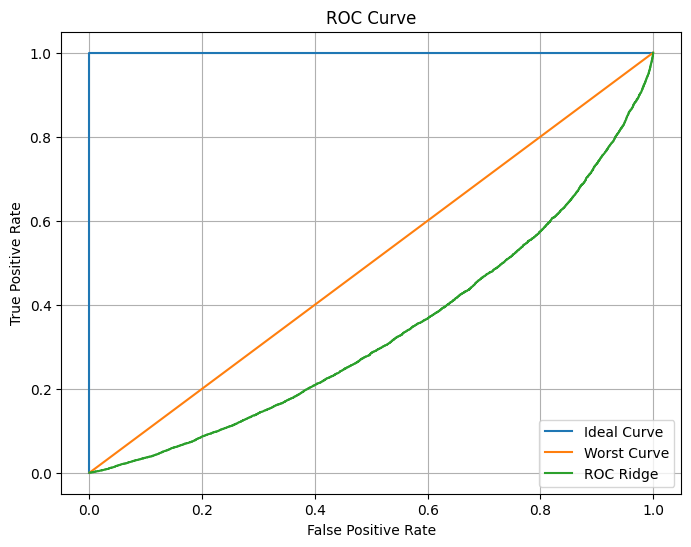

In [187]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=pol_regr.predict_proba(test_set)[:, 0])
worst_curve = np.linspace(0,1,100)
ideal_curve = np.ones(100)

plt.figure(figsize = (8, 6))
plt.plot([0]+list(worst_curve),[0]+list(ideal_curve))
plt.plot(worst_curve, worst_curve)
plt.plot(fpr,tpr)

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(['Ideal Curve','Worst Curve', 'ROC Ridge'])

plt.show()

Our regressor continues to perform poorly. Let's try lasso regression.

### Lasso Regression

In [ ]:
pol_regr = Pipeline([
    ('polynomial_expansion', PolynomialFeatures()),
    ('logit_regressor', LogisticRegression(penalty='l1'))
])

gs = GridSearchCV(pol_regr, param_grid={'polynomial_expansion__degree': range(1, 5),
                                        'logit_regressor__C': np.arange(1.0, 0, -0.1)},
                  scoring=make_scorer(fbeta_score, beta=2))

gs.fit(train_set, y_train)

In [149]:
np.array_equal(pol_regr.predict_proba(test_set), log_regr.predict_proba(test_set))

False

In [173]:
pol_regr = Pipeline([
    ('polynomial_expansion', PolynomialFeatures()),
    ('logit_regressor', LogisticRegression(penalty='l1', solver='liblinear'))
])

In [174]:
pol_regr.set_params(polynomial_expansion__degree=1, logit_regressor__C = 0.2)

Pipeline(steps=[('polynomial_expansion', PolynomialFeatures(degree=1)),
                ('logit_regressor',
                 LogisticRegression(C=0.2, penalty='l1', solver='liblinear'))])

In [175]:
pol_regr.fit(train_set, y_train)

Pipeline(steps=[('polynomial_expansion', PolynomialFeatures(degree=1)),
                ('logit_regressor',
                 LogisticRegression(C=0.2, penalty='l1', solver='liblinear'))])

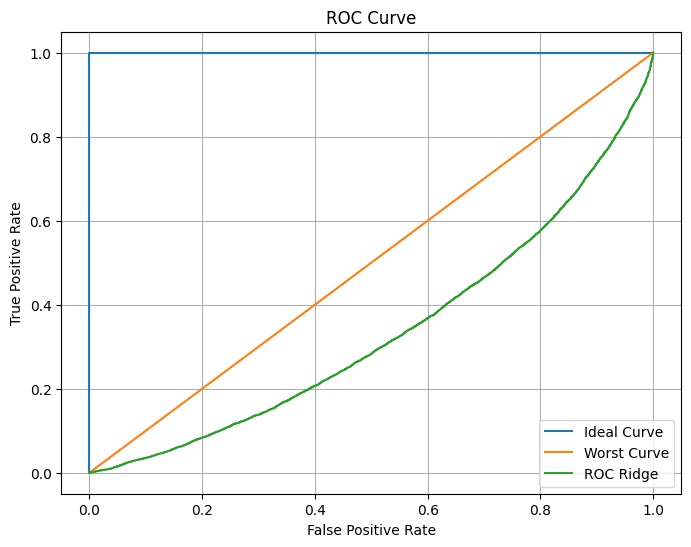

In [176]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=pol_regr.predict_proba(test_set)[:, 0])
worst_curve = np.linspace(0,1,100)
ideal_curve = np.ones(100)

plt.figure(figsize = (8, 6))
plt.plot([0]+list(worst_curve),[0]+list(ideal_curve))
plt.plot(worst_curve, worst_curve)
plt.plot(fpr,tpr)

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(['Ideal Curve','Worst Curve', 'ROC Ridge'])

plt.show()

In [ ]:
y_pred = pol_regr.predict(test_set)
scores_df['LR_Lasso'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [178]:
scores_df

,LR,LR_Lasso,LR_Lasso2
recall_score,0.403588,0.400000,0.402050
precision_score,0.650958,0.650278,0.650449
accuracy,0.626037,0.624975,0.625486
f1_score,0.498260,0.495319,0.496938
fbeta_score,0.436785,0.433358,0.435297


## Principal Component (Logit) Regression

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
components = pca.fit(X=view.drop(columns='readmitted'))

### Choosing the right number of components

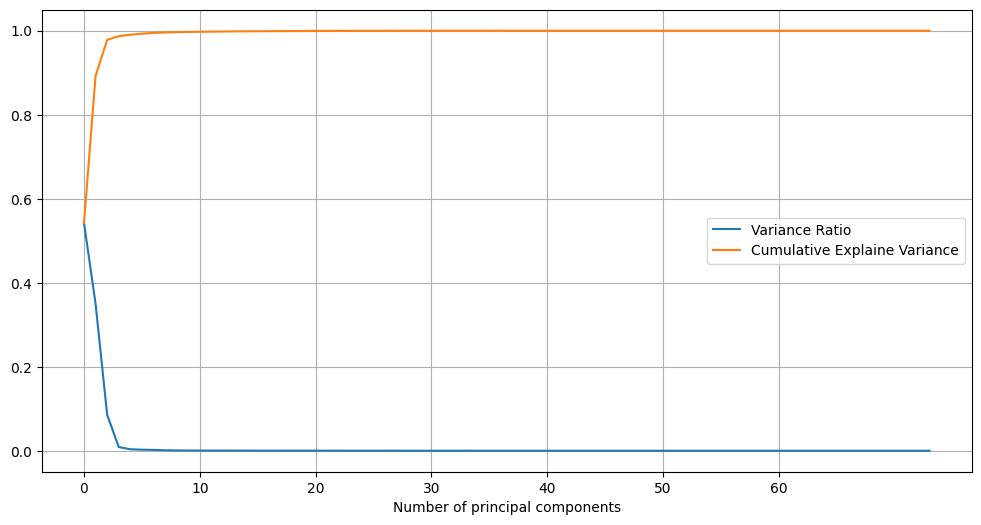

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot( components.explained_variance_ratio_)
plt.plot(np.cumsum(components.explained_variance_ratio_))
plt.xlabel("Number of principal components")
plt.xticks(ticks=range(0, 61, 10))
plt.legend(['Variance Ratio', 'Cumulative Explaine Variance'])
plt.grid()

In [ ]:
print(np.cumsum(components.explained_variance_ratio_)[:10])

[0.54278455 0.89248216 0.97814418 0.98694693 0.99043732 0.99289522
 0.99487688 0.99590204 0.99661112 0.9970913 ]


The first 10 components explains almost all the variance (99,7%)

In [ ]:
pca = PCA(n_components=10)
X = pca.fit_transform(view.drop(columns='readmitted'))

### Building the regressor

Let's split our new data in train set and test set.

In [ ]:
train_set, test_set, y_train, y_test = train_test_split(X, view['readmitted'], test_size=0.25)  

In [ ]:
model = sm.Logit(exog=train_set, endog=y_train).fit()

Optimization terminated successfully.
         Current function value: 0.657718
         Iterations 6


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                76322
Model:                          Logit   Df Residuals:                    76312
Method:                           MLE   Df Model:                            9
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                 0.04688
Time:                        16:45:43   Log-Likelihood:                -50198.
converged:                       True   LL-Null:                       -52667.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0045      0.000     11.981      0.000       0.004       0.005
x2             0.0021      0.000      4.368      0.000       0.001       0.003
x3             0.0103      0.001     10.853      0.000       0.008       0.012
x4             0.0219      0.003      7.371      0.000       0.016       0.028
x5            -0.1980      0.005    -39.606      0.000      -0.208      -0.188
x6             0.3828      0.008     50.866      0.000       0.368       0.398
x7            -0.2238      0.008    -27.658      0.000      -0.240      -0.208
x8             0.1277      0.015      8.520      0.000       0.098       0.157
x9            -0.0778      0.010     -7.448      0.000      -0.098      -0.057
x10            0.0330      0.013      2.612      0.009       0.008       0.058
==============================================================================
"""

Let's see how well our model performs on the test set. <br> For now, let's use a treshold of 0.5 We will say that a patient X will be readmitted if $P(Y=1|X) >0.5$

In [ ]:
y_score = model.predict(test_set)

In [ ]:
y_pred = y_score.round().astype(int)

In [ ]:
scores_df['PCR'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [ ]:
scores_df

,PCR
recall_score,0.449548
precision_score,0.611382
accuracy,0.614323
f1_score,0.518122
fbeta_score,0.474678


Let's also compute the normalized confusion matrix:

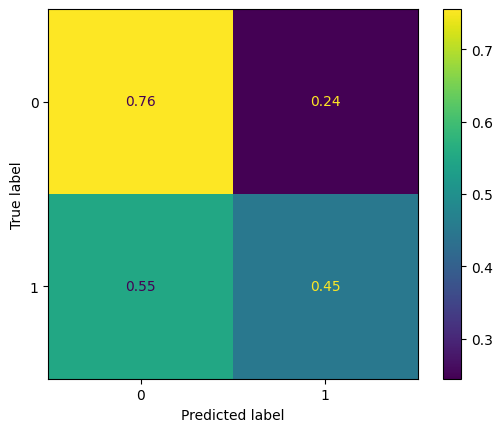

In [ ]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm=cm/cm.sum(1).reshape(-1, 1)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

We have a TPR (recall) of 0.45!! Can we do better with another treshold? Let's USE a ROC curve to find out.

### ROC curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)
worst_curve = np.linspace(0,1,100)
ideal_curve = np.ones(100)

plt.figure(figsize = (8, 6))
plt.plot([0]+list(worst_curve),[0]+list(ideal_curve))
plt.plot(worst_curve, worst_curve)
plt.plot(fpr,tpr)

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(['Ideal Curve','Worst Curve', 'ROC'])

plt.show()

In [ ]:
roc_auc_score(y_true=y_test, y_score=y_score)

np.float64(0.6458743116937995)

We have an AUC of 0.65. Our model is better than a random classifier, however it is far from being a good classifier.
Let's choose the treshold that maximes the difference $\frac{2}{3}*TPR + \frac{1}{3}(1-FPR)$

In [ ]:
scores = (2/3)*tpr + (1/3)*(1-fpr)

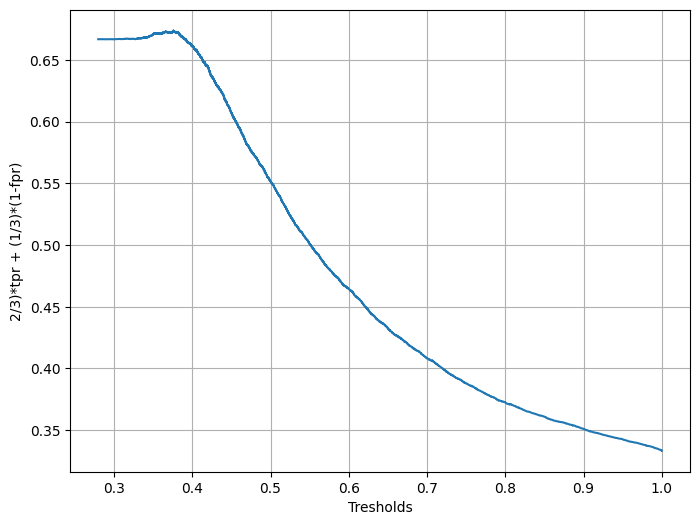

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, scores)
plt.xlabel('Tresholds')
plt.ylabel('2/3)*tpr + (1/3)*(1-fpr)')
plt.grid()
plt.show()

In [ ]:
thresholds[np.argmax(scores)]

np.float64(0.37583630582174277)

Let's use or new treshold to perform prediction.

In [ ]:
y_pred = np.uint8(y_score > 0.37)

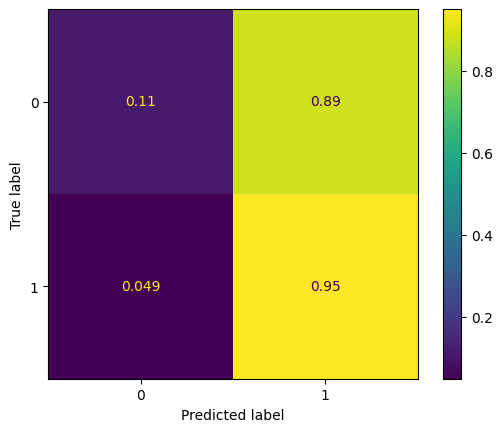

In [ ]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm=cm/cm.sum(1).reshape(-1, 1)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

In [ ]:
scores_df['PCR'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [ ]:
scores_df

,PCR
recall_score,0.951253
precision_score,0.478994
accuracy,0.500295
f1_score,0.637155
fbeta_score,0.794573


In [ ]:
fb_scores = [f1_score(y_true=y_test, y_pred= np.uint8(y_score > i)) for i in thresholds]

In [ ]:
thresholds[np.argmax(fb_scores)]

np.float64(0.27980176346397806)

In [ ]:
y_pred = np.uint8(y_score > 0.28)


In [ ]:
scores_df['PCR'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [ ]:
scores_df

,PCR
recall_score,1.000000
precision_score,0.461242
accuracy,0.461263
f1_score,0.631301
fbeta_score,0.810628


### Polynomial expansion

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
pol_features = PolynomialFeatures(2)
pol_features.fit_transform

### Ridge and Lasso logit regression

## Linear Discriminant Analysis


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda = lda.fit(train_set, y_train)

In [ ]:
y_pred = lda.predict(test_set)

In [ ]:
scores_df['LDA'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [ ]:
scores_df

,PCR,LDA
recall_score,1.000000,0.334839
precision_score,0.461242,0.635041
accuracy,0.461263,0.604457
f1_score,0.631301,0.438480
fbeta_score,0.810628,0.369802


## Quadratic Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [ ]:
qda = QDA()
qua = qda.fit(train_set, y_train)
y_pred = qda.predict(test_set)

In [ ]:
scores_df['QDA'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [ ]:
scores_df

,PCR,LDA,QDA
recall_score,1.000000,0.334839,0.216465
precision_score,0.461242,0.635041,0.677153
accuracy,0.461263,0.604457,0.591015
f1_score,0.631301,0.438480,0.328059
fbeta_score,0.810628,0.369802,0.250557


## K-Nearest Neighbor classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN



### Hyperparameter selection using K-fold cross validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

param_grid = [ {'n_neighbors':range(1, 10)}]

gs = GridSearchCV(KNN(), param_grid, cv=kf, scoring='recall', n_jobs=-1, refit=True)

gs.fit(X=train_set.drop(columns='readmitted'), y=train_set['readmitted'])

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': range(1, 10)}], scoring='recall')

#f1 sbilanciato valore es 2 per beta

In [ ]:
gs.best_params_

{'n_neighbors': 1}

In [ ]:
knn = gs.best_estimator_  

In [ ]:
y_pred = knn.predict(X=test_set)

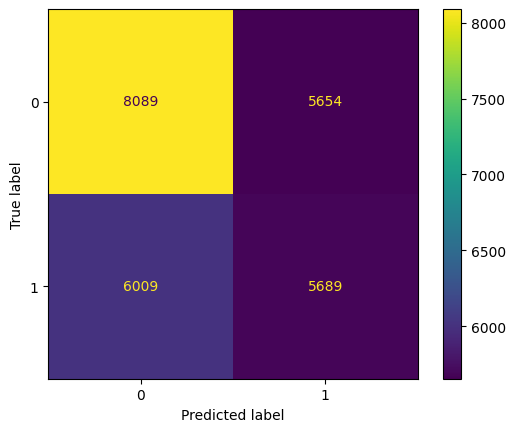

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred=y_pred, y_true=y_test), display_labels=[0, 1]).plot()

In [ ]:
scores_df['KNN'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2), accuracy_score(y_true=y_test, y_pred=y_pred)]

In [ ]:
scores_df

Recall:  0.4863224482817576
Precision:  0.501542801727938
F1:  0.4938153725966755
Accuracy:  0.5415667623128022


In [ ]:
best_params = gs.cv_results_['params']
print(best_params)


[{'n_neighbors': 1}, {'n_neighbors': 2}, {'n_neighbors': 3}, {'n_neighbors': 4}, {'n_neighbors': 5}, {'n_neighbors': 6}, {'n_neighbors': 7}, {'n_neighbors': 8}, {'n_neighbors': 9}]


# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier().fit(train_set, y_train)

In [ ]:
y_pred = mlp.predict(test_set)

In [ ]:
scores_df['MLP'] = [recall_score(y_true=y_test, y_pred=y_pred), precision_score(y_true=y_test, y_pred=y_pred),
                    accuracy_score(y_true=y_test, y_pred=y_pred), f1_score(y_true=y_test, y_pred=y_pred), fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)]

In [ ]:
scores_df

,MLP
recall_score,0.476393
precision_score,0.613651
accuracy,0.618804
f1_score,0.536380
fbeta_score,0.498702


## Classifiers comparison

# Conclusions